In [1]:
!pip install pyspark

In [2]:
import pyspark
from pyspark.sql import SparkSession
spark=SparkSession.builder.getOrCreate()

In [3]:
df=spark.read.csv('hdfs://localhost:9000/data/fraudTrain.csv',header=True,inferSchema=True)
df.show(5)

+---+---------------------+----------------+--------------------+-------------+------+---------+-------+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+
|_c0|trans_date_trans_time|          cc_num|            merchant|     category|   amt|    first|   last|gender|              street|          city|state|  zip|    lat|     long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat| merch_long|is_fraud|
+---+---------------------+----------------+--------------------+-------------+------+---------+-------+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+
|  0|  2019-01-01 00:00:18|2703186189652095|fraud_Rippin, Kub...|     misc_net|  4.97| Jennifer|  Banks|     F|      561 Perry 

Training data contains almost 1.3 million records

In [4]:
df=df.drop('_c0')
df.show(5)

+---------------------+----------------+--------------------+-------------+------+---------+-------+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+
|trans_date_trans_time|          cc_num|            merchant|     category|   amt|    first|   last|gender|              street|          city|state|  zip|    lat|     long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat| merch_long|is_fraud|
+---------------------+----------------+--------------------+-------------+------+---------+-------+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+
|  2019-01-01 00:00:18|2703186189652095|fraud_Rippin, Kub...|     misc_net|  4.97| Jennifer|  Banks|     F|      561 Perry Cove|Moravian Fa

In [5]:
df.printSchema()

root
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)



#Preprocessing

In [6]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *
def ageCol(transaction_date,dob):
  return transaction_date.year-dob.year
ageColFunction=udf(lambda x,y: ageCol(x,y),IntegerType())
df=df.withColumn("Age",ageColFunction(df["trans_date_trans_time"],df["dob"]))

In [7]:
def ageBin(age):
  return (age//10)
ageBinFunction=udf(lambda x: ageBin(x),IntegerType())
df=df.withColumn("Age_bin",ageBinFunction(df["age"]))

In [8]:
df.show(5)

+---------------------+----------------+--------------------+-------------+------+---------+-------+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+---+-------+
|trans_date_trans_time|          cc_num|            merchant|     category|   amt|    first|   last|gender|              street|          city|state|  zip|    lat|     long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat| merch_long|is_fraud|Age|Age_bin|
+---------------------+----------------+--------------------+-------------+------+---------+-------+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+---+-------+
|  2019-01-01 00:00:18|2703186189652095|fraud_Rippin, Kub...|     misc_net|  4.97| Jennifer|  Banks|   

In [9]:
def hourOfTran(trans_date):
  return trans_date.hour
hourOfTranFunction=udf(lambda x: hourOfTran(x),IntegerType())
df=df.withColumn("hour_of_transaction",hourOfTranFunction(df["trans_date_trans_time"]))

In [10]:
df.show()

+---------------------+-------------------+--------------------+-------------+------+-----------+---------+------+--------------------+--------------------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+------------------+--------+---+-------+-------------------+
|trans_date_trans_time|             cc_num|            merchant|     category|   amt|      first|     last|gender|              street|                city|state|  zip|    lat|              long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat|        merch_long|is_fraud|Age|Age_bin|hour_of_transaction|
+---------------------+-------------------+--------------------+-------------+------+-----------+---------+------+--------------------+--------------------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+-----------------

In [11]:
def distanceCalculate(long,lat,merch_long,merch_lat):
  result=((lat-merch_lat)**2 +(long-merch_long)**2)**0.5
  return result
distanceCalculateFunction=udf(lambda a,b,c,d: distanceCalculate(a,b,c,d), FloatType())
df=df.withColumn("distance",distanceCalculateFunction(df["long"],df["lat"],df["merch_long"],df["merch_lat"]))

In [12]:
df.show(5)

+---------------------+----------------+--------------------+-------------+------+---------+-------+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+---+-------+-------------------+----------+
|trans_date_trans_time|          cc_num|            merchant|     category|   amt|    first|   last|gender|              street|          city|state|  zip|    lat|     long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat| merch_long|is_fraud|Age|Age_bin|hour_of_transaction|  distance|
+---------------------+----------------+--------------------+-------------+------+---------+-------+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+---+-------+-------------------+----------+
|  2019-01

In [13]:
df.select("amt").describe().show()

+-------+------------------+
|summary|               amt|
+-------+------------------+
|  count|           1296675|
|   mean| 70.35103545607072|
| stddev|160.31603857152723|
|    min|               1.0|
|    max|           28948.9|
+-------+------------------+



In [14]:
from pyspark.sql.functions import log1p
df=df.withColumn("log_amt",log1p(df["amt"]))
df=df.withColumn("log_city_pop",log1p(df["city_pop"]))

In [15]:
df.show(5)

+---------------------+----------------+--------------------+-------------+------+---------+-------+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+---+-------+-------------------+----------+------------------+------------------+
|trans_date_trans_time|          cc_num|            merchant|     category|   amt|    first|   last|gender|              street|          city|state|  zip|    lat|     long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat| merch_long|is_fraud|Age|Age_bin|hour_of_transaction|  distance|           log_amt|      log_city_pop|
+---------------------+----------------+--------------------+-------------+------+---------+-------+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+------------------

In [16]:
dfProcessed=df.select('category', 'log_amt', 'gender', 'log_city_pop', 'Age_bin','hour_of_transaction', 'distance', 'is_fraud')

In [17]:
dfProcessed.show(5)

+-------------+------------------+------+------------------+-------+-------------------+----------+--------+
|     category|           log_amt|gender|      log_city_pop|Age_bin|hour_of_transaction|  distance|is_fraud|
+-------------+------------------+------+------------------+-------+-------------------+----------+--------+
|     misc_net|1.7867469274045107|     F| 8.159374736775426|      3|                  0| 0.8728295|       0|
|  grocery_pos| 4.684258592307055|     F|5.0106352940962555|      4|                  0|0.27231005|       0|
|entertainment| 5.398660315244065|     M| 8.332067707289548|      5|                  0|0.97584534|       0|
|gas_transport| 3.828641396489095|     M| 7.570443252057374|      5|                  0|0.91980153|       0|
|     misc_pos|3.7602694502006093|     M| 4.605170185988092|      3|                  0| 0.8685046|       0|
+-------------+------------------+------+------------------+-------+-------------------+----------+--------+
only showing top 5 

In [18]:
import matplotlib.pyplot as plt
pandas_df=dfProcessed.toPandas()
pandas_df.head(5)

,category,log_amt,gender,log_city_pop,Age_bin,hour_of_transaction,distance,is_fraud
0,misc_net,1.786747,F,8.159375,3,0,0.872829,0
1,grocery_pos,4.684259,F,5.010635,4,0,0.272310,0
2,entertainment,5.398660,M,8.332068,5,0,0.975845,0
3,gas_transport,3.828641,M,7.570443,5,0,0.919802,0
4,misc_pos,3.760269,M,4.605170,3,0,0.868505,0


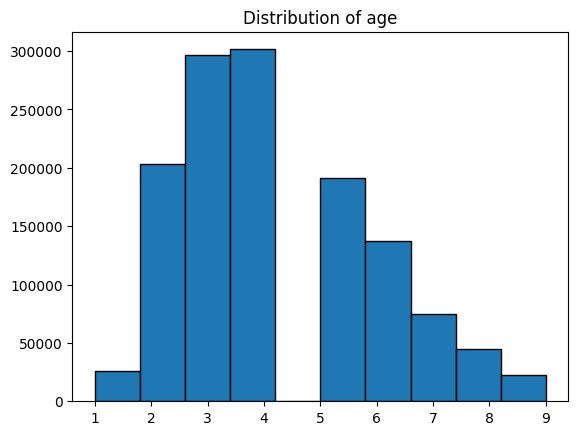

In [19]:
plt.hist(pandas_df["Age_bin"],edgecolor = "black")
plt.title("Distribution of age")
plt.show()

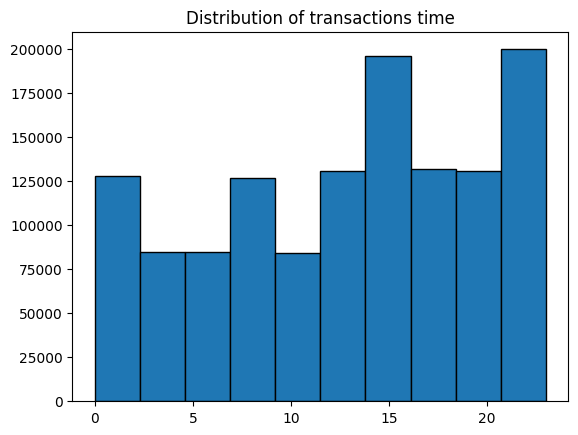

In [20]:
plt.hist(pandas_df["hour_of_transaction"],edgecolor="black")
plt.title("Distribution of transactions time")
plt.show()

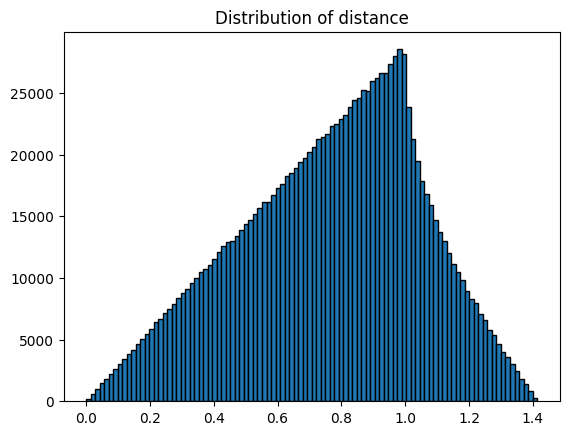

In [21]:
plt.hist(pandas_df["distance"],edgecolor="black",bins=100)
plt.title("Distribution of distance")
plt.show()

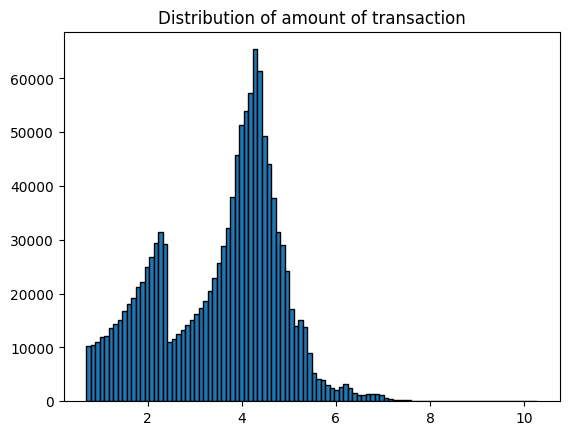

In [22]:
plt.hist(pandas_df["log_amt"],edgecolor="black",bins=100)
plt.title("Distribution of amount of transaction")
plt.show()

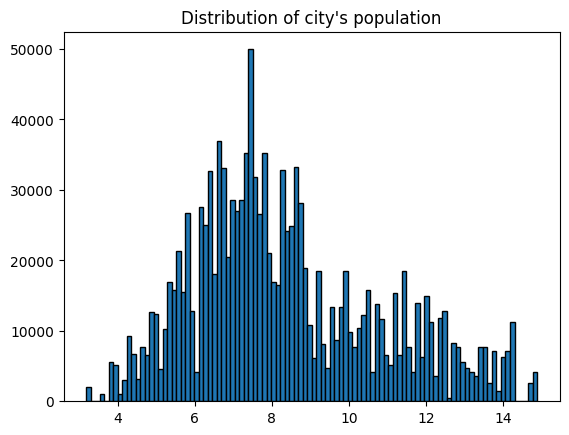

In [23]:
plt.hist(pandas_df["log_city_pop"],edgecolor="black",bins=100)
plt.title("Distribution of city's population")
plt.show()

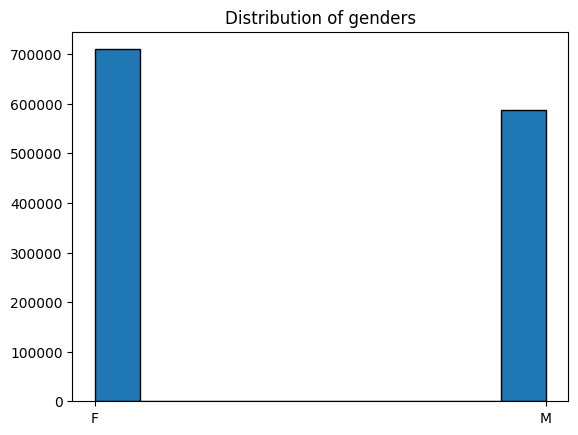

In [24]:
plt.hist(pandas_df["gender"],edgecolor="black")
plt.title("Distribution of genders")
plt.show()

#Training the model

In [25]:
features_col=dfProcessed.columns[:-1]
target_col=dfProcessed.columns[-1]
X_train=dfProcessed.drop("is_fraud")
Y_train=dfProcessed.select("is_fraud")

In [26]:
from pyspark.sql.types import NumericType
def get_numeric_columns(df):
    numeric_cols = []
    for field in df.schema.fields:
        if isinstance(field.dataType, NumericType):
            numeric_cols.append(field.name)
    return numeric_cols

def get_categorical_columns(df):
    categorical_cols = []
    for field in df.schema.fields:
        if isinstance(field.dataType, StringType):
            categorical_cols.append(field.name)
    return categorical_cols

numeric_cols = get_numeric_columns(X_train)
categorical_cols = get_categorical_columns(X_train)

In [27]:
print(numeric_cols)
print(categorical_cols)

['log_amt', 'log_city_pop', 'Age_bin', 'hour_of_transaction', 'distance']
['category', 'gender']


In [28]:
corr_matrix = pandas_df.corr(numeric_only=True)
corr_matrix[target_col].sort_values(ascending=False)
corr_matrix

,log_amt,log_city_pop,Age_bin,hour_of_transaction,distance,is_fraud
log_amt,1.000000,-0.017132,-0.030368,-0.139897,-0.001228,0.120439
log_city_pop,-0.017132,1.000000,-0.153431,0.032669,0.000757,0.001582
Age_bin,-0.030368,-0.153431,1.000000,-0.172354,-0.001129,0.012161
hour_of_transaction,-0.139897,0.032669,-0.172354,1.000000,-0.000752,0.013799
distance,-0.001228,0.000757,-0.001129,-0.000752,1.000000,0.000434
is_fraud,0.120439,0.001582,0.012161,0.013799,0.000434,1.000000


#Testing the model

In [29]:
df_test=spark.read.csv('hdfs://localhost:9000/data/fraudTest.csv',inferSchema=True,header=True)
df_test.show(5)

+---+---------------------+----------------+--------------------+--------------+-----+------+--------+------+--------------------+----------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+
|_c0|trans_date_trans_time|          cc_num|            merchant|      category|  amt| first|    last|gender|              street|      city|state|  zip|    lat|              long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat| merch_long|is_fraud|
+---+---------------------+----------------+--------------------+--------------+-----+------+--------+------+--------------------+----------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+
|  0|  2020-06-21 12:14:25|2291163933867244|fraud_Kirlin and ...| personal_care| 2.86|  Jeff| Elliott|     M|   351 Da

preprocessing the test dataset

In [30]:
df_test=df_test.withColumn("Age",ageColFunction(df_test["trans_date_trans_time"],df_test["dob"]))
df_test=df_test.withColumn("Age_bin",ageBinFunction(df_test["age"]))
df_test=df_test.withColumn("hour_of_transaction",hourOfTranFunction(df_test["trans_date_trans_time"]))
df_test=df_test.withColumn("distance",distanceCalculateFunction(df_test["long"],df_test["lat"],df_test["merch_long"],df_test["merch_lat"]))
df_test=df_test.withColumn("log_amt",log1p(df_test["amt"]))
df_test=df_test.withColumn("log_city_pop",log1p(df_test["city_pop"]))
df_test_processed=df_test.select('category', 'log_amt', 'gender', 'log_city_pop', 'Age_bin','hour_of_transaction', 'distance', 'is_fraud')

combining the two datasets

In [31]:
combineddf=dfProcessed.unionByName(df_test_processed)

In [32]:
combineddf.show(5)

+-------------+------------------+------+------------------+-------+-------------------+----------+--------+
|     category|           log_amt|gender|      log_city_pop|Age_bin|hour_of_transaction|  distance|is_fraud|
+-------------+------------------+------+------------------+-------+-------------------+----------+--------+
|     misc_net|1.7867469274045107|     F| 8.159374736775426|      3|                  0| 0.8728295|       0|
|  grocery_pos| 4.684258592307055|     F|5.0106352940962555|      4|                  0|0.27231005|       0|
|entertainment| 5.398660315244065|     M| 8.332067707289548|      5|                  0|0.97584534|       0|
|gas_transport| 3.828641396489095|     M| 7.570443252057374|      5|                  0|0.91980153|       0|
|     misc_pos|3.7602694502006093|     M| 4.605170185988092|      3|                  0| 0.8685046|       0|
+-------------+------------------+------+------------------+-------+-------------------+----------+--------+
only showing top 5 

Dummy classifier in pyspark

In [33]:
from pyspark.sql.functions import lit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import DoubleType

mostFreqClass = combineddf.groupBy('is_fraud').count().orderBy('count', ascending=False).first()['is_fraud']
trainWithPredictions = combineddf.withColumn('prediction', lit(mostFreqClass).cast(DoubleType()))
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="f1")
accuracy = evaluator_accuracy.evaluate(trainWithPredictions)
precision = evaluator_precision.evaluate(trainWithPredictions)
recall = evaluator_recall.evaluate(trainWithPredictions)
f1 = evaluator_f1.evaluate(trainWithPredictions)

print(f"Dummy Accuracy: {accuracy:.2f}")
print(f"Dummy Precision: {precision:.2f}")
print(f"Dummy Recall: {recall:.2f}")
print(f"Dummy F1 Score: {f1:.2f}")

Dummy Accuracy: 0.99
Dummy Precision: 0.99
Dummy Recall: 0.99
Dummy F1 Score: 0.99


Logistic Regression

In [41]:
combineddf=dfProcessed.unionByName(df_test_processed)
traindata,testdata=combineddf.randomSplit([0.8,0.2],42)

In [42]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in categorical_cols]
encoders = [OneHotEncoder(inputCol=column+"_index", outputCol=column+"_ohe") for column in categorical_cols]
assembler_num = VectorAssembler(inputCols=numeric_cols, outputCol="numeric_vector")
scaler = StandardScaler(inputCol="numeric_vector", outputCol="numeric_scaled")
assembler = VectorAssembler(inputCols=[column+"_ohe" for column in categorical_cols] + ["numeric_scaled"], outputCol="features")
lr = LogisticRegression(featuresCol='features', labelCol='is_fraud')
pipeline = Pipeline(stages=indexers + encoders + [assembler_num, scaler, assembler, lr])
model = pipeline.fit(traindata)

In [43]:
#Performance
predictions = model.transform(testdata)
evaluator = BinaryClassificationEvaluator(labelCol='is_fraud')
accuracy_lr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
precision_lr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
recall_lr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
f1_lr = 2 * (precision_lr * recall_lr) / (precision_lr + recall_lr)

print(f"Logistic Regression Accuracy: {accuracy_lr:.2f}")
print(f"Logistic Regression Precision: {precision_lr:.2f}")
print(f"Logistic Regression Recall: {recall_lr:.2f}")
print(f"Logistic Regression F1 Score: {f1_lr:.2f}")

Logistic Regression Accuracy: 0.84
Logistic Regression Precision: 0.35
Logistic Regression Recall: 0.35
Logistic Regression F1 Score: 0.35


Random Forest

In [44]:
from pyspark.ml.classification import RandomForestClassifier

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in categorical_cols]
encoders = [OneHotEncoder(inputCol=column+"_index", outputCol=column+"_ohe") for column in categorical_cols]
assembler_num = VectorAssembler(inputCols=numeric_cols, outputCol="numeric_vector")
scaler = StandardScaler(inputCol="numeric_vector", outputCol="numeric_scaled")
assembler = VectorAssembler(inputCols=[column+"_ohe" for column in categorical_cols] + ["numeric_scaled"], outputCol="features")
rf = RandomForestClassifier(featuresCol='features', labelCol='is_fraud')
pipeline = Pipeline(stages=indexers + encoders + [assembler_num, scaler, assembler, rf])
model = pipeline.fit(traindata)

In [45]:
#Performance
predictions = model.transform(testdata)
evaluator = BinaryClassificationEvaluator(labelCol='is_fraud')
accuracy_rf = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
precision_rf = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
recall_rf = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
f1_rf = 2 * (precision_rf * recall_rf) / (precision_rf + recall_rf)

print(f"Random Forest Accuracy: {accuracy_rf:.2f}")
print(f"Random Forest Precision: {precision_rf:.2f}")
print(f"Random Forest Recall: {recall_rf:.2f}")
print(f"Random Forest F1 Score: {f1_rf:.2f}")

Random Forest Accuracy: 0.97
Random Forest Precision: 0.60
Random Forest Recall: 0.60
Random Forest F1 Score: 0.60
